# **Assignment for Data Science Interns**
The dataset shared herewith is from the informatics department of a hospital which has patient level
vitals for each patient they have on ICU beds and the corresponding alerts based on the status of their
experiencing a code-blue event (viz. "Coded" = "high-risk":1 or 'low-risk' :0). The Schema for this dataset
is shared below :
# **Features and Description:**
vitals_datetime
Time at which the patient got admitted to the hospital

heart_rate
Patient vital

respiration_over_impedence
Patient vital

spirometry_oxygen_saturation
Patient vital

pulse
Patient vital

blood_pressure_systolic
Patient vital

blood_pressure_diastolic
Patient vital

blood_pressure_average
Patient vital

patient_id
Unique-id of the patient

machine_id
Unique machine id (ICU bed ID)

Coded
Actual alerts [high-risk/low-risk]

The dataset is divided into two csv files training_frame.csv for training a model that predicts the status of
a code-blue event either on the day-of or one day ahead of the event. The test_frame.csv is meant for
testing out-of-sample.

● Build models to predict the Coded column of the training frame and test the model on out of
sample data i.e. test_frame, after aggregating the data by patient, by day.

● Mark a patient-day combination as a high-risk event if there was at least one code-blue event on
that day.

● Develop multiple models and choose the best one or build an ensemble of these models to
determine code-blue risk.

● Document your code and approach.

Submit your code as a Jupyter notebook that can run on Google Colab. Submit “assignment.ipynb” file to
us

In [1]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Required Libraries**

In [2]:
#Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# **Load Data**

In [3]:
# Read Data
train = pd.read_csv('/content/drive/MyDrive/Assignment/training_frame.csv')
test = pd.read_csv('/content/drive/MyDrive/Assignment/test_frame.csv')

In [4]:
train.head()

,Unnamed: 0,vitals_datetime,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,machine_id,Coded
0,0,2020-03-28 23:00:25+00:00,111.0,44.0,100.0,110.0,111.0,74.0,79.0,1585133,MICU-11,0.0
1,1,2020-03-28 23:01:10+00:00,85.0,12.0,97.0,92.0,95.0,60.0,77.0,1406566,BAY13-BZ,0.0
2,2,2020-03-28 23:30:29+00:00,92.0,6.0,99.0,92.0,113.0,71.0,93.0,1360999,SICU-09,0.0
3,3,2020-03-28 23:30:29+00:00,64.0,22.0,96.0,65.0,128.0,80.0,88.0,276287,NSU-03,0.0
4,4,2020-03-28 23:30:32+00:00,111.0,22.0,96.0,102.0,100.0,64.0,72.0,1267452,MICU-04,0.0


In [5]:
#Droping Unnamed column
train.drop('Unnamed: 0',axis=1,inplace=True)
train.head(2)

,vitals_datetime,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,machine_id,Coded
0,2020-03-28 23:00:25+00:00,111.0,44.0,100.0,110.0,111.0,74.0,79.0,1585133,MICU-11,0.0
1,2020-03-28 23:01:10+00:00,85.0,12.0,97.0,92.0,95.0,60.0,77.0,1406566,BAY13-BZ,0.0


In [6]:
#Last 5rows
train.tail()

,vitals_datetime,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,machine_id,Coded
99995,2020-05-28 13:50:41+00:00,152.0,46.0,96.0,115.0,122.0,80.0,88.0,1818083,6BTELE-18,1.0
99996,2020-05-28 13:50:41+00:00,152.0,46.0,96.0,115.0,122.0,80.0,88.0,1818083,6BTELE-18,1.0
99997,2020-05-28 13:50:42+00:00,128.0,22.0,100.0,126.0,185.0,157.0,167.0,1541456,6WNTX-19,1.0
99998,2020-05-28 13:50:42+00:00,128.0,22.0,100.0,126.0,185.0,157.0,167.0,1541456,6WNTX-19,1.0
99999,2020-05-28 13:50:43+00:00,73.0,38.0,94.0,69.0,149.0,88.0,112.0,1784388,NSU-02,1.0


# **Data Analysis**

In [7]:
#Shape(rows,columns)
train.shape

(100000, 11)

In [8]:
# Data types
train.dtypes

vitals_datetime                  object
heart_rate                      float64
respiration_over_impedence      float64
spirometry_oxygen_saturation    float64
pulse                           float64
blood_pressure_systolic         float64
blood_pressure_diastolic        float64
blood_pressure_average          float64
patient_id                        int64
machine_id                       object
Coded                           float64
dtype: object

In [9]:
#Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vitals_datetime               100000 non-null  object 
 1   heart_rate                    100000 non-null  float64
 2   respiration_over_impedence    100000 non-null  float64
 3   spirometry_oxygen_saturation  100000 non-null  float64
 4   pulse                         100000 non-null  float64
 5   blood_pressure_systolic       100000 non-null  float64
 6   blood_pressure_diastolic      100000 non-null  float64
 7   blood_pressure_average        100000 non-null  float64
 8   patient_id                    100000 non-null  int64  
 9   machine_id                    100000 non-null  object 
 10  Coded                         100000 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 8.4+ MB


In [10]:
#Duplicates
train.duplicated().sum()

11049

In [11]:
# Droping Duplicated entries
train.drop_duplicates(inplace=True)

#Confirmation
train.duplicated().sum()


0

# **Missing Values**

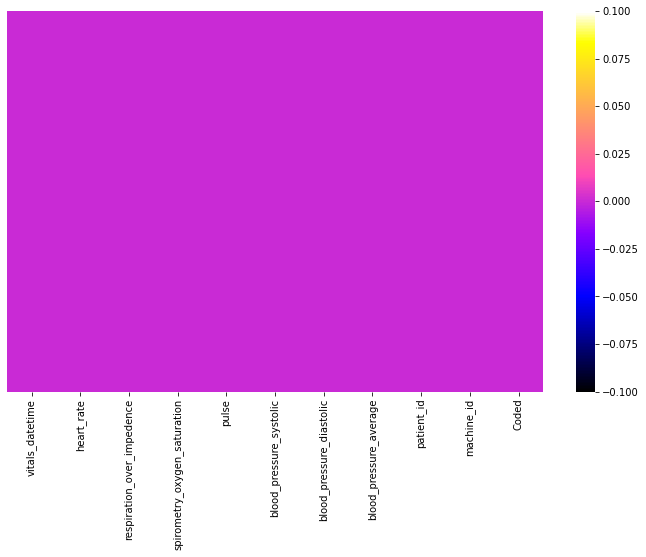

In [12]:
# Check for missing Values
plt.figure(figsize=(12,7))
sns.heatmap(train.isnull(),yticklabels=False,cmap='gnuplot2')

In [13]:
#Confirmation
train.isnull().sum()

vitals_datetime                 0
heart_rate                      0
respiration_over_impedence      0
spirometry_oxygen_saturation    0
pulse                           0
blood_pressure_systolic         0
blood_pressure_diastolic        0
blood_pressure_average          0
patient_id                      0
machine_id                      0
Coded                           0
dtype: int64

# **Exploratory Data Analysis**
Now, Lets explore the data further to gain better understanding about the problem and to extract relevant information.

In [14]:
#Features
train.columns

Index(['vitals_datetime', 'heart_rate', 'respiration_over_impedence',
       'spirometry_oxygen_saturation', 'pulse', 'blood_pressure_systolic',
       'blood_pressure_diastolic', 'blood_pressure_average', 'patient_id',
       'machine_id', 'Coded'],
      dtype='object')

In [15]:
# Check datetime
train['vitals_datetime'].unique()

array(['2020-03-28 23:00:25+00:00', '2020-03-28 23:01:10+00:00',
       '2020-03-28 23:30:29+00:00', ..., '2020-05-28 13:50:41+00:00',
       '2020-05-28 13:50:42+00:00', '2020-05-28 13:50:43+00:00'],
      dtype=object)

In [16]:
print(train['heart_rate'].mean())
print(train['respiration_over_impedence'].mean())
print(train['pulse'].mean())
print(train['blood_pressure_systolic'].mean())
print(train['blood_pressure_diastolic'].mean())
print(train['blood_pressure_average'].mean())

93.62119593933738
20.279468471405604
90.57107845892682
128.05835797236682
73.79003046621173
90.5961596834212


In [17]:
# Number of unique machines
print(train['machine_id'].unique())

['MICU-11' 'BAY13-BZ' 'SICU-09' 'NSU-03' 'MICU-04' 'NSU-02' 'NSU-01'
 'NSU-06' 'MICU-03' 'MICU-09' 'MICU-02' 'SICU-07' 'BAY22-BZ' 'MICU-05'
 'MICU-07' 'MICU-01' 'SICU-02' '6WNTX-23' 'BAY16' 'SICU-12' 'SICU-08'
 'SICU-11' 'SICU-03' 'MICU-12' 'NSU-05' '6WNTX-22' 'MICU-06' 'MICU-08'
 'BAY17-BZ' '6WNTX-02' 'MICU-10' 'SICU-10' '9B-TELE21' '6BNTX-01'
 'BAY7-BZ' 'BAY12-BZ' 'BAY14-BZ' 'BAY-8' 'BAY3-BZ' 'BAY5-BZ' '9B-TELE16'
 'SICU-6' 'SICU-5' '6WNTX-14' 'NSU-04' 'BAY19-BZ' 'BAY26-BZ' '9B-TELE23'
 'BAY10-BZ' 'BAY4-BZ' 'BAY27-BZ' 'ISOLATION' '6WTELE-03' '6WTELE-09'
 '9B-TEL02' 'BAY42-GZ' '6BTELE-21' '6BTELE-23' '9B-TELE15' '6WTELE-01'
 '6WTELE-04' 'BAY18-BZ' '9B-TELE25' 'SICU-4' '9BNTX-9094' '6BTELE-17'
 'SICU-04' 'SICU-01' '9BNTX-9114' '6BTELE-05' '9B-TELE24' '6BTELE-13'
 '6WNTX-10' 'BAY25-BZ' 'BAY40-GZ' 'BAY37-GZ' '6WTELE-11' '6WNTX-24'
 'BAY34-GZ' '6BTELE-18' '6BNTX-07' '6BTELE-24' 'BAY35-GZ' '6WNTX-15'
 'BAY38-GZ' '6BNTX-05' '6BTELE-28' '6BTELE-07' '6BTELE-29' '6BNTX-02'
 '6BNTX-06' '6BTELE-

In [18]:
train['Coded'].value_counts()

0.0    70000
1.0    18951
Name: Coded, dtype: int64

# **Observations:**
- There are 100k-rows & 11-features
- No missing values with 11049 duplicated entries
- Time period is from 28-march - 28th-may-2020
- There are 109-unique machine_id

# **Descriptive Statistics**

In [19]:
# Statistical Summary
train.describe()
# An outlier is present in the respiration_over_impedence

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,Coded
count,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,8.895100e+04,88951.000000
mean,93.621196,20.279468,96.836348,90.571078,128.058358,73.790030,90.596160,1.299682e+06,0.213050
std,24.613189,37.849321,4.583335,19.967101,25.828967,15.777556,19.106761,5.422712e+05,0.409465
min,0.000000,-7499.000000,12.000000,33.000000,29.000000,13.000000,15.000000,1.679400e+04,0.000000
25%,75.000000,15.000000,96.000000,75.000000,108.000000,62.000000,77.000000,1.129477e+06,0.000000
50%,91.000000,19.000000,98.000000,90.000000,128.000000,73.000000,89.000000,1.370617e+06,0.000000
75%,107.000000,24.000000,100.000000,102.000000,146.000000,83.000000,102.000000,1.817642e+06,0.000000
max,233.000000,150.000000,100.000000,292.000000,261.000000,267.000000,279.000000,9.038929e+06,1.000000


In [20]:
# Check outlier
train.describe(percentiles = [0.1,0.05,0.09])

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,Coded
count,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,8.895100e+04,88951.000000
mean,93.621196,20.279468,96.836348,90.571078,128.058358,73.790030,90.596160,1.299682e+06,0.213050
std,24.613189,37.849321,4.583335,19.967101,25.828967,15.777556,19.106761,5.422712e+05,0.409465
min,0.000000,-7499.000000,12.000000,33.000000,29.000000,13.000000,15.000000,1.679400e+04,0.000000
5%,61.000000,0.000000,91.000000,61.000000,88.000000,52.000000,64.000000,1.571390e+05,0.000000
9%,65.000000,7.000000,93.000000,65.000000,93.000000,55.000000,67.000000,1.630080e+05,0.000000
10%,66.000000,8.000000,93.000000,66.000000,93.000000,55.000000,68.000000,2.617090e+05,0.000000
50%,91.000000,19.000000,98.000000,90.000000,128.000000,73.000000,89.000000,1.370617e+06,0.000000
max,233.000000,150.000000,100.000000,292.000000,261.000000,267.000000,279.000000,9.038929e+06,1.000000


In [21]:
# Check outlier
train.describe(percentiles = [0.9,0.95,0.99])

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,Coded
count,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,88951.000000,8.895100e+04,88951.000000
mean,93.621196,20.279468,96.836348,90.571078,128.058358,73.790030,90.596160,1.299682e+06,0.213050
std,24.613189,37.849321,4.583335,19.967101,25.828967,15.777556,19.106761,5.422712e+05,0.409465
min,0.000000,-7499.000000,12.000000,33.000000,29.000000,13.000000,15.000000,1.679400e+04,0.000000
50%,91.000000,19.000000,98.000000,90.000000,128.000000,73.000000,89.000000,1.370617e+06,0.000000
90%,122.000000,31.000000,100.000000,115.000000,159.000000,94.000000,116.000000,1.819487e+06,1.000000
95%,141.000000,42.000000,100.000000,126.000000,171.000000,99.000000,123.000000,1.819660e+06,1.000000
99%,163.500000,65.000000,100.000000,143.000000,196.000000,112.000000,142.000000,1.819816e+06,1.000000
max,233.000000,150.000000,100.000000,292.000000,261.000000,267.000000,279.000000,9.038929e+06,1.000000


# **Visualizations**

In [22]:
#Check Correlations between features
train.corr()

,heart_rate,respiration_over_impedence,spirometry_oxygen_saturation,pulse,blood_pressure_systolic,blood_pressure_diastolic,blood_pressure_average,patient_id,Coded
heart_rate,1.000000,0.077417,-0.155852,0.667205,-0.066396,0.156786,0.012588,-0.005404,-0.045087
respiration_over_impedence,0.077417,1.000000,0.015755,0.070022,0.024332,0.024011,0.015007,0.044961,-0.001615
spirometry_oxygen_saturation,-0.155852,0.015755,1.000000,-0.050409,0.157931,0.108731,0.152541,0.105421,-0.048017
pulse,0.667205,0.070022,-0.050409,1.000000,-0.048833,0.231967,0.075960,0.073658,-0.069293
blood_pressure_systolic,-0.066396,0.024332,0.157931,-0.048833,1.000000,0.631260,0.821025,0.015580,0.024343
blood_pressure_diastolic,0.156786,0.024011,0.108731,0.231967,0.631260,1.000000,0.850132,-0.056524,0.045468
blood_pressure_average,0.012588,0.015007,0.152541,0.075960,0.821025,0.850132,1.000000,-0.038138,0.044518
patient_id,-0.005404,0.044961,0.105421,0.073658,0.015580,-0.056524,-0.038138,1.000000,-0.175699
Coded,-0.045087,-0.001615,-0.048017,-0.069293,0.024343,0.045468,0.044518,-0.175699,1.000000


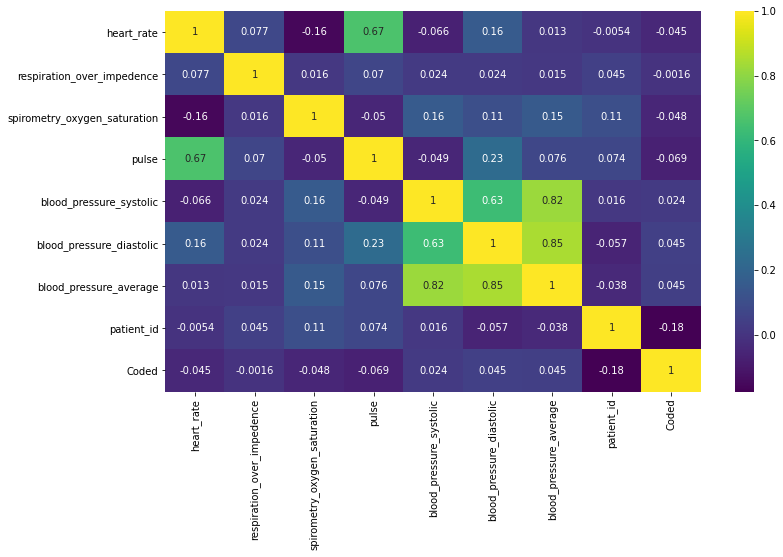

In [23]:
plt.figure(figsize=(12,7))
sns.heatmap(train.corr(),cmap='viridis',annot=True)

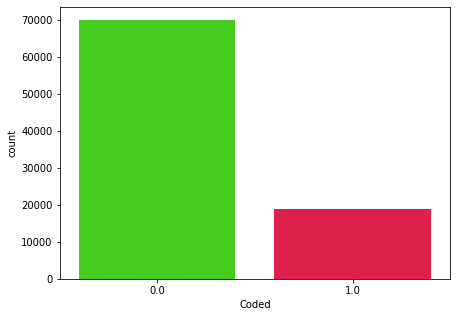

In [24]:
plt.figure(figsize=(7,5))
sns.countplot(x='Coded',data=train,palette='prism')

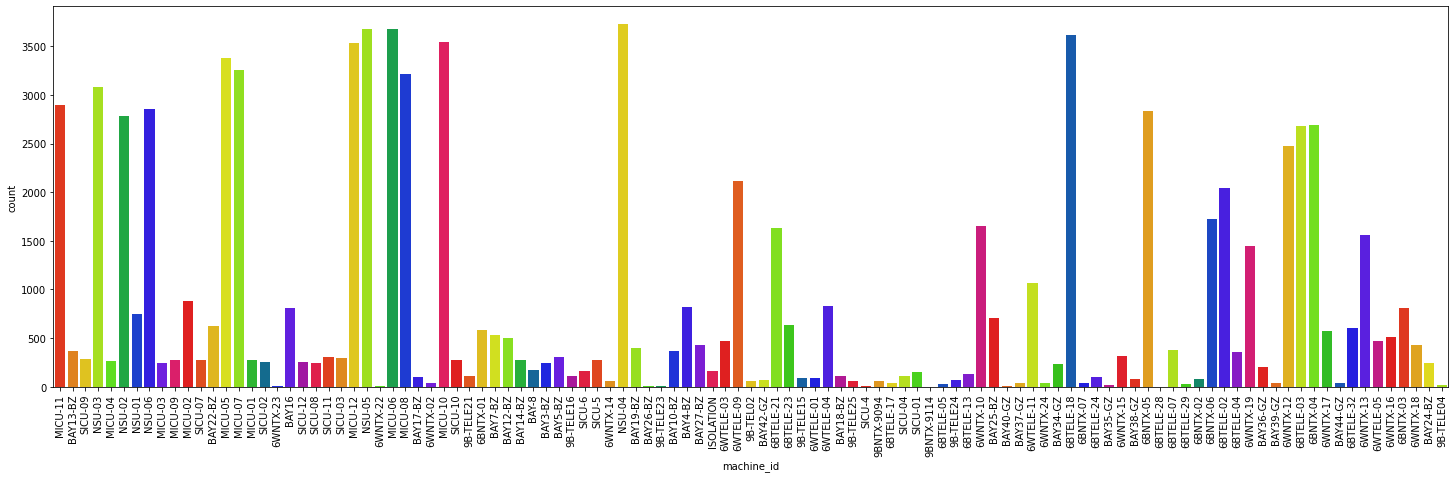

In [25]:
plt.figure(figsize=(25,7))
plt.xticks(rotation=90)
sns.countplot(x='machine_id',data=train,palette='prism')

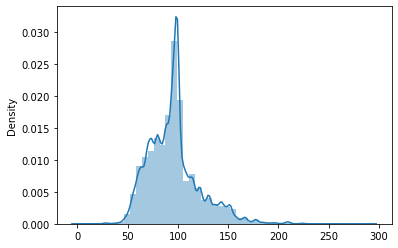

In [26]:
sns.distplot(train[['heart_rate','spirometry_oxygen_saturation','pulse','blood_pressure_systolic',
                    'blood_pressure_diastolic','blood_pressure_average']])

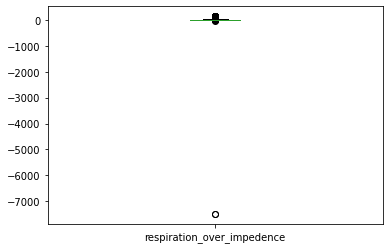

In [27]:
#Detecting outliers
train['respiration_over_impedence'].plot.box()

# **Visual Inferences:**
- There are two coded values a)High-risk:1 & b)Low-risk:0
- Different types of machine_ids are used.
- An outlier is present in "respiration_over_impedence" column

# **Feature Engineering**
Since, some of the featues doesn't make sense lets impute them by encoding it.

In [28]:
# First I drop the vatals_datetime,patients_id columns as I don't find that it contribute any relevant information
train.drop('vitals_datetime',axis=1,inplace=True)
train.drop('patient_id',axis=1,inplace=True)

In [29]:
# Now, I am going to label encode the machine_id & coded features
# Encoding 
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['machine_id']=le.fit_transform(train['machine_id'])
train['Coded']=le.fit_transform(train['Coded'])

# Confirmation
train.dtypes

heart_rate                      float64
respiration_over_impedence      float64
spirometry_oxygen_saturation    float64
pulse                           float64
blood_pressure_systolic         float64
blood_pressure_diastolic        float64
blood_pressure_average          float64
machine_id                        int64
Coded                             int64
dtype: object

In [30]:
# Check skewness 
train.skew()

heart_rate                        1.174732
respiration_over_impedence     -176.184147
spirometry_oxygen_saturation     -3.592676
pulse                             0.584124
blood_pressure_systolic           0.302054
blood_pressure_diastolic          0.999762
blood_pressure_average            0.710114
machine_id                       -0.374875
Coded                             1.401617
dtype: float64

In [31]:
#Removing Outliers
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
zscore = abs(zscore(train))
print(train.shape)

(88951, 9)


In [32]:
#Setting threshold frequency
threshold = 3
print(np.where(zscore>3))

(array([   10,    12,    45, ..., 88944, 88949, 88949]), array([6, 0, 5, ..., 2, 5, 6]))


In [33]:
# Create new_df
new_train=train[(zscore<3).all(axis=1)]
print(train.shape)
print()
print(new_train.shape)

(88951, 9)

(84510, 9)


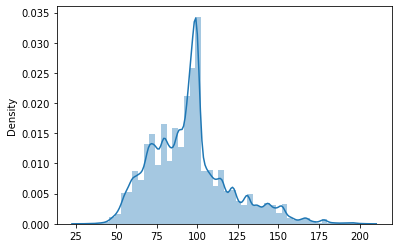

In [34]:
#Check distributions
sns.distplot(new_train[['heart_rate','spirometry_oxygen_saturation','pulse','blood_pressure_systolic',
                    'blood_pressure_diastolic','blood_pressure_average']])

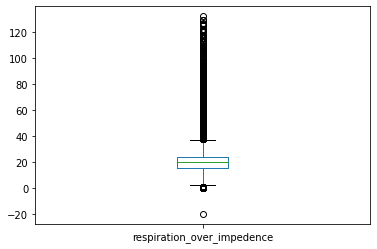

In [35]:
#Successfully remove extreme outliers
new_train['respiration_over_impedence'].plot.box()

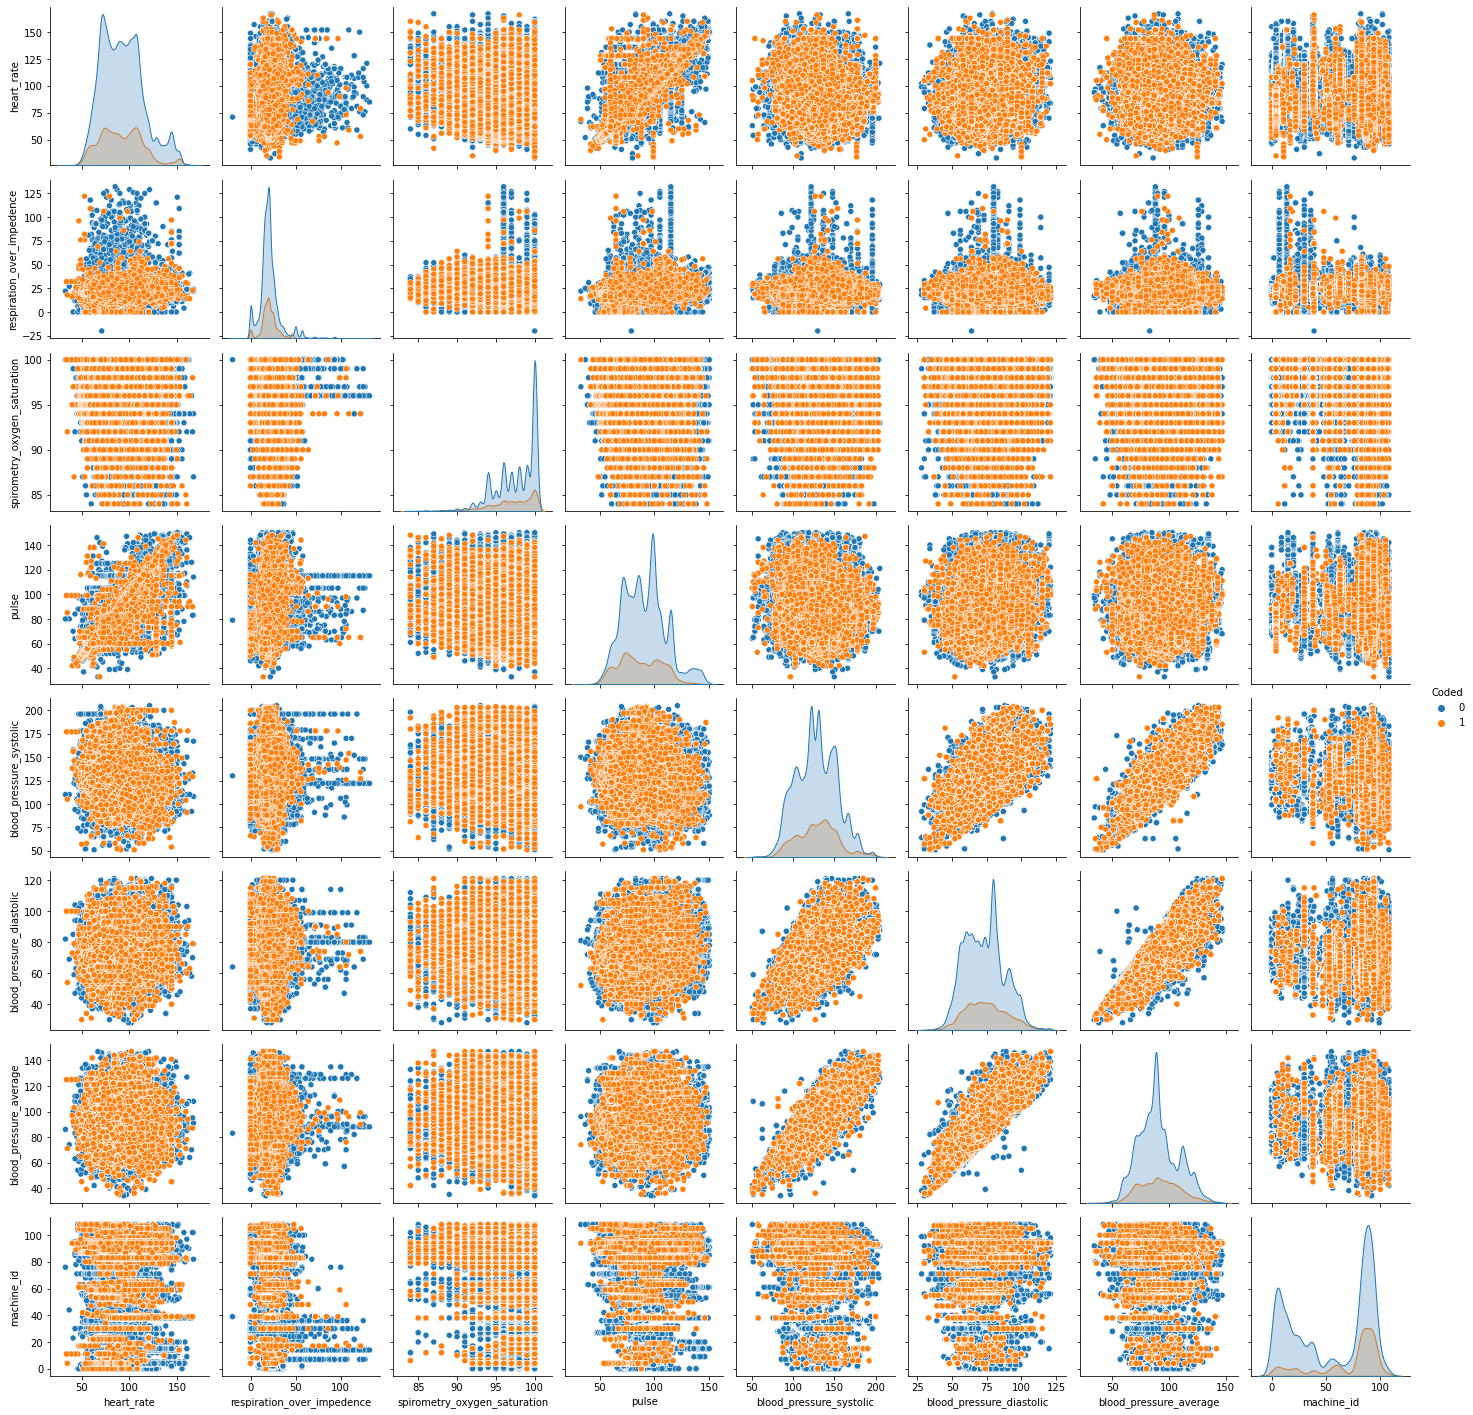

In [36]:
#Pairplot
sns.pairplot(new_train,hue='Coded')

In [37]:
# Scaling the data
sc = StandardScaler()
x = sc.fit_transform(new_train)
x = pd.DataFrame(x,columns=new_train.columns)
x.shape

(84510, 9)

In [38]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score

In [39]:
pca=PCA(n_components=8)
x=pca.fit_transform(x)
y=new_train.iloc[:,8].values
print(y)

[0 0 0 ... 1 1 1]


In [40]:
le=LabelEncoder()
y=le.fit_transform(y)
print(y)

[0 0 0 ... 1 1 1]


# **Splitting the data into training and testing**

In [41]:
# Splitting  data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=11,stratify=y)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(59157, 8) (25353, 8)
(59157,) (25353,)


# **Importing Machine Learning Algorithm**

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [43]:
#Models
LR=LogisticRegression()
DT=DecisionTreeClassifier(random_state=6)
GNB=GaussianNB()

In [44]:
#Appending models
models = []
models.append(('LogisticRegression',LR))
models.append(('DecisionTreeClassifier',DT))
models.append(('GaussianNB',GNB))

In [45]:
Model = []
score = []
cvs=[]
rocscore=[]

# **Predictions**

Model : LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy_Score =  1.0
Cross_Val_Score =  1.0
roc_auc_score =  1.0
Classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19931
           1       1.00      1.00      1.00      5422

    accuracy                           1.00     25353
   macro avg       1.00      1.00      1.00     25353
weighted avg       1.00      1.00      1.00     25353

[[19931     0]
 [    0  5422]]
AxesSubplot(0.125,0.808774;0.62x0.0712264)
Model : DecisionTreeClassifier
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features

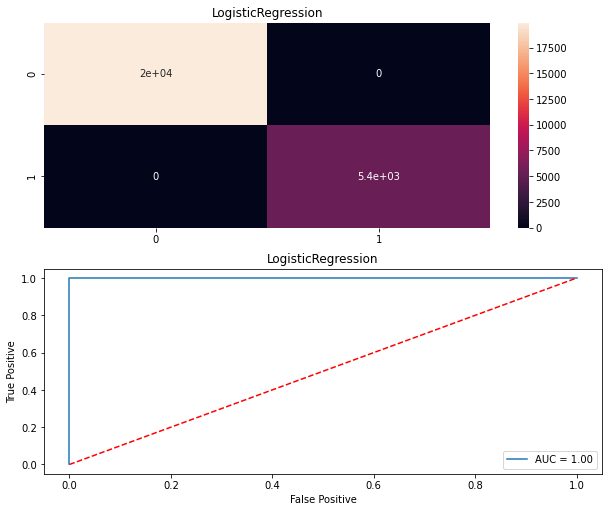

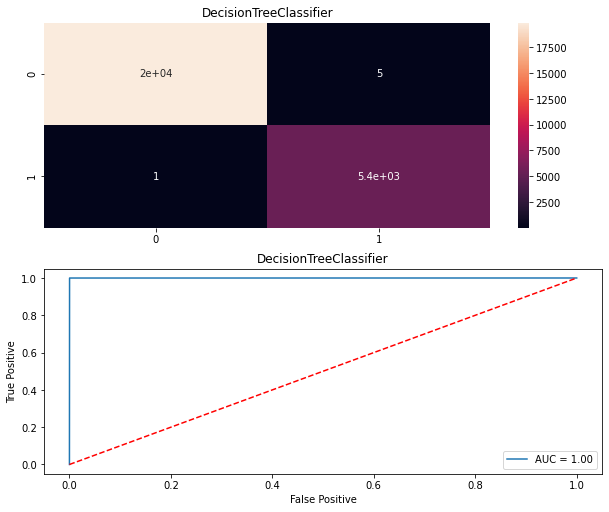

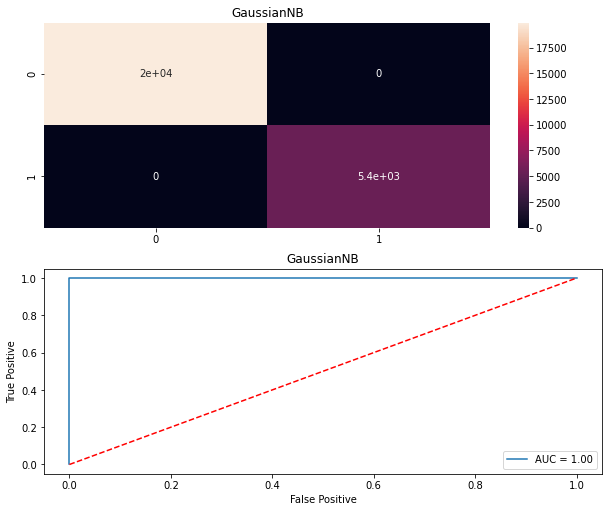

In [46]:

for n_model,model in models:
    print(f"Model : {n_model}")
    Model.append(n_model)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    AS=accuracy_score(y_test,pre)
    print('Accuracy_Score = ',AS)
    score.append(AS*100)
    sc = cross_val_score(model, x, y, cv=10, scoring='accuracy').mean()
    print('Cross_Val_Score = ',sc)
    cvs.append(sc*100)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pre)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('roc_auc_score = ',roc_auc)
    rocscore.append(roc_auc*100)
    print('Classification_report\n',classification_report(y_test,pre))
    cm=confusion_matrix(y_test,pre)
    print(cm)
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(n_model)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(n_model)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive')
    plt.xlabel('False Positive')

In [47]:
Output = pd.DataFrame({'Model': Model, 'Accuracy_score': score,'Cross_val_score':cvs,'Roc_auc_curve':rocscore})
Output

,Model,Accuracy_score,Cross_val_score,Roc_auc_curve
0,LogisticRegression,100.000000,100.000000,100.000000
1,DecisionTreeClassifier,99.976334,99.942019,99.978235
2,GaussianNB,100.000000,99.646196,100.000000


# **Result-**
From the above we can clearly see that LogisticRegression & GaussianNB are completely overfitted model. So,I choose DecisionTreeClassifier as my final model because it perform well on the dataset

1.) Accuracy_score is 99.97

2.) Cross_val_score is 99.94

3.) Roc_auc_curve is 99.97